In [64]:
import jax
import numpy as np
import gcsfs
import neuralgcm
import xarray

# load demo model
checkpoint = neuralgcm.demo.load_checkpoint_tl63_stochastic()
model = neuralgcm.PressureLevelModel.from_checkpoint(checkpoint)

# create a xarray.Dataset with required variables for NeuralGCM
gcs = gcsfs.GCSFileSystem(token='anon')
path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(path), chunks=None)
full_era5 = full_era5[model.input_variables + model.forcing_variables]

In [65]:
full_era5

<xarray.Dataset> Size: 1PB
Dimensions:                              (time: 1323648, level: 37,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 11MB 1900-01-0...
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 203TB ...
    specific_humidity                    (time, level, latitude, longitude) float32 203TB ...
    temperature                          (time, level, latitude, longitude) float32 203TB ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 203TB ...
    sea_ice_cover                        (time, latitude, longitude) float32 5TB ...
    sea_surface_temperature              (time, latitude, longitude) float32 5TB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [66]:
from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils

full_era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
# Other available regridders include BilinearRegridder and NearestRegridder.
regridder = horizontal_interpolation.ConservativeRegridder(
    full_era5_grid, model.data_coords.horizontal, skipna=True
)

In [67]:
regridder

ConservativeRegridder(source_grid=Grid(longitude_wavenumbers=0, total_wavenumbers=0, longitude_nodes=1440, latitude_nodes=721, latitude_spacing='equiangular_with_poles', longitude_offset=np.float32(0.0), radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonics'>, spmd_mesh=None), target_grid=Grid(longitude_wavenumbers=64, total_wavenumbers=65, longitude_nodes=128, latitude_nodes=64, latitude_spacing='gauss', longitude_offset=0.0, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonicsWithZeroImag'>, spmd_mesh=None))

In [68]:
full_era5.nbytes / 1e12

1434.731939297004

In [69]:
sliced_era5 = full_era5.sel(time='2020-01-01T00').compute()

In [70]:
sliced_era5

<xarray.Dataset> Size: 1GB
Dimensions:                              (level: 37, latitude: 721,
                                          longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
    time                                 datetime64[ns] 8B 2020-01-01
Data variables:
    geopotential                         (level, latitude, longitude) float32 154MB ...
    specific_humidity                    (level, latitude, longitude) float32 154MB ...
    temperature                          (level, latitude, longitude) float32 154MB ...
    u_component_of_wind                  (level, latitude, longitude) float32 154MB ...
    v_component_of_wind                  (level, latitude, longitude) float32 154MB ...
    specific_cloud_ice_water_content     (level, latitude, longitude) float32 154MB ...
    specific_cloud_liquid_water_content  (level, latitude, longitude) float32 154MB ...
    sea_ice_cover                        (latitude, longitude) float32 4MB 1....
    sea_surface_temperature              (latitude, longitude) float32 4MB 27...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [71]:
regridded = xarray_utils.regrid(sliced_era5, regridder)

In [72]:
regridded

<xarray.Dataset> Size: 9MB
Dimensions:                              (level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * level                                (level) int64 296B 1 2 3 ... 975 1000
    time                                 datetime64[ns] 8B 2020-01-01
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
Data variables:
    geopotential                         (level, longitude, latitude) float32 1MB ...
    specific_humidity                    (level, longitude, latitude) float32 1MB ...
    temperature                          (level, longitude, latitude) float32 1MB ...
    u_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    v_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 1MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 1MB ...
    sea_ice_cover                        (longitude, latitude) float32 33kB n...
    sea_surface_temperature              (longitude, latitude) float32 33kB n...

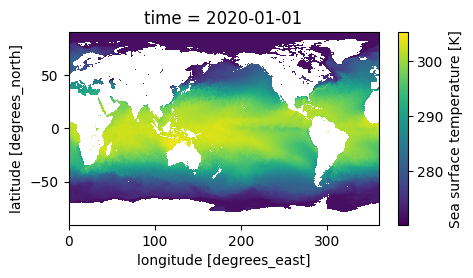

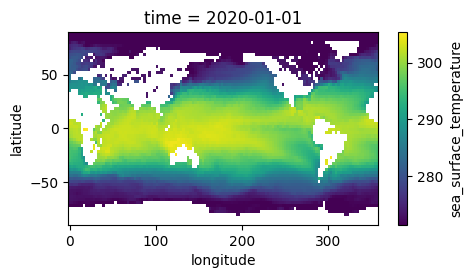

In [73]:
sliced_era5.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);
regridded.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

In [74]:
regridded_and_filled = xarray_utils.fill_nan_with_nearest(regridded)

In [87]:
regridded_and_filled 

<xarray.Dataset> Size: 9MB
Dimensions:                              (level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * level                                (level) int64 296B 1 2 3 ... 975 1000
    time                                 datetime64[ns] 8B 2020-01-01
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
Data variables:
    geopotential                         (level, longitude, latitude) float32 1MB ...
    specific_humidity                    (level, longitude, latitude) float32 1MB ...
    temperature                          (level, longitude, latitude) float32 1MB ...
    u_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    v_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 1MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 1MB ...
    sea_ice_cover                        (longitude, latitude) float32 33kB 0...
    sea_surface_temperature              (longitude, latitude) float32 33kB 2...

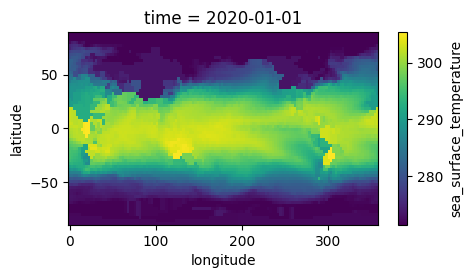

In [75]:
regridded_and_filled.sea_surface_temperature.plot(x='longitude', y='latitude', aspect=2, size=2.5);

In [76]:
inputs = model.inputs_from_xarray(regridded_and_filled)
forcings = model.forcings_from_xarray(regridded_and_filled)
rng_key = jax.random.key(42)

In [77]:
jax.tree.map(np.shape, inputs)

{'geopotential': (37, 128, 64),
 'sim_time': (),
 'specific_cloud_ice_water_content': (37, 128, 64),
 'specific_cloud_liquid_water_content': (37, 128, 64),
 'specific_humidity': (37, 128, 64),
 'temperature': (37, 128, 64),
 'u_component_of_wind': (37, 128, 64),
 'v_component_of_wind': (37, 128, 64)}

In [78]:
jax.tree.map(np.shape, forcings)

{'sea_ice_cover': (1, 128, 64),
 'sea_surface_temperature': (1, 128, 64),
 'sim_time': ()}

In [79]:
inputs['sim_time']

array(188693.6256)

In [80]:
model.datetime64_to_sim_time(regridded_and_filled.time.data)

np.float64(188693.6256)

In [81]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times_ = (np.arange(outer_steps) * inner_steps) 

In [83]:
model.data_to_xarray(
    model.inputs_from_xarray(regridded_and_filled),
    times=None,  # times=None indicates no leading time-axis
)

<xarray.Dataset> Size: 8MB
Dimensions:                              (level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
  * level                                (level) int64 296B 1 2 3 ... 975 1000
Data variables:
    specific_humidity                    (level, longitude, latitude) float32 1MB ...
    v_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 1MB ...
    temperature                          (level, longitude, latitude) float32 1MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 1MB ...
    sim_time                             float64 8B 1.887e+05
    u_component_of_wind                  (level, longitude, latitude) float32 1MB ...
    geopotential                         (level, longitude, latitude) float32 1MB ...
Attributes:
    longitude_wavenumbers:     64
    total_wavenumbers:         65
    longitude_nodes:           128
    latitude_nodes:            64
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

In [84]:
xarray_utils.selective_temporal_shift(
    dataset=full_era5,
    variables=model.forcing_variables,
    time_shift='24 hours',
)

<xarray.Dataset> Size: 1PB
Dimensions:                              (time: 1323624, level: 37,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 11MB 1900-01-0...
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 203TB ...
    specific_humidity                    (time, level, latitude, longitude) float32 203TB ...
    temperature                          (time, level, latitude, longitude) float32 203TB ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 203TB ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 203TB ...
    sea_ice_cover                        (time, latitude, longitude) float32 5TB ...
    sea_surface_temperature              (time, latitude, longitude) float32 5TB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [85]:
import pickle

In [86]:
model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

/tmp/ipykernel_151515/1359244622.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ckpt = pickle.load(f)
